# Hymba 논문 리뷰 Part 5: 구현 검증 및 Attention Map 분석

## 직접 구현하고, 학습하고, 시각화하기

---

**시리즈 구성**
- [Part 1: 개요 및 연구 배경](./05_1.Hymba_Overview.ipynb)
- [Part 2: Meta Token 심층 분석](./05_2.Hymba_MetaToken.ipynb)
- [Part 3: SWA + Global Attention](./05_3.Hymba_SWA.ipynb)
- [Part 4: KV Cache Sharing](./05_4.Hymba_KVSharing.ipynb)
- **Part 5: 구현 검증 및 Attention Map 분석** ← 현재
- [Part 6: 비판적 분석 및 결론](./05_6.Hymba_Conclusion.ipynb)

---

> **핵심 요약**: 앞서 분석한 모든 컴포넌트(Meta Token, SWA, KV Sharing)를 통합하여 Hymba Attention을 구현하고, 실제 학습 후 Attention Map을 분석합니다.

---

**📊 실제 학습 결과 (04.Hymba_Evaluation.ipynb에서 수행)**

```
실험 환경:
  - 데이터셋: WikiText-2
  - 학습: 10 epochs, batch size 128
  - 모델 규모: ~28M 파라미터

최종 성능 비교:
┌─────────────────────┬──────────┬───────────┬───────────┐
│ 모델                │ 파라미터  │ Final PPL │ 학습시간   │
├─────────────────────┼──────────┼───────────┼───────────┤
│ Mamba-only          │ 28.05M   │ 1.02      │ 183s      │
│ Transformer-only    │ 27.80M   │ 1.02      │ 229s      │
│ Hymba (직접 구현)    │ 29.96M   │ 1.01 ✓    │ 325s      │
│ Hymba (공식)         │ 27.46M   │ 1.02      │ 443s      │
└─────────────────────┴──────────┴───────────┴───────────┘

→ 직접 구현한 Hymba가 최저 Perplexity (1.01) 달성!
```

**Attention Map 분석 결과:**
- **Global 레이어 (L0, L4, L7)**: 전체 시퀀스에 분산된 attention
- **Local 레이어 (L1, L2, L3, L5, L6)**: 뚜렷한 대각선 패턴 (SWA window=64)
- **Meta Token 영역**: 모든 레이어에서 일관되게 높은 attention 수신

![Hymba Attention Maps](./results/hybrid_mine_attention_maps.png)

In [1]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
 
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
    name='NanumGothicBold')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumGothicBold', 'axes.unicode_minus': False})

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple, List

## 1. 통합 Hymba Attention 구현

### 1.1 핵심 컴포넌트 정리

Hymba Attention은 다음 기법들을 통합합니다:

1. **Meta Token**: 학습 가능한 토큰으로 Attention Sink 문제 해결
2. **Sliding Window Attention (SWA)**: 지역적 컨텍스트에 집중
3. **Global Attention Layer**: 전역 정보 통합 (특정 레이어에서만)
4. **KV Cache Sharing**: 레이어 간 KV 공유로 메모리 절감

### 1.2 수학적 정의

**Attention Mask 수식**:

$$\text{Mask}[i,j] = \text{Causal}[i,j] \land (\text{InWindow}[i,j] \lor \text{IsMeta}[j])$$

여기서:
- $\text{Causal}[i,j] = (j \leq i)$
- $\text{InWindow}[i,j] = (i - j < w)$ where $w$ is window size
- $\text{IsMeta}[j] = (j < m)$ where $m$ is number of meta tokens

In [2]:
class HymbaAttention(nn.Module):
    """
    완전한 Hymba Attention 구현
    - Meta Token
    - Sliding Window Attention
    - Global/Local Layer 선택
    - KV Sharing 지원
    """
    
    def __init__(
        self,
        d_model: int,
        num_heads: int,
        num_meta_tokens: int = 16,
        window_size: int = 256,
        is_global_layer: bool = False,
        is_kv_producer: bool = True,
        dropout: float = 0.0
    ):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.num_meta_tokens = num_meta_tokens
        self.window_size = window_size
        self.is_global_layer = is_global_layer
        self.is_kv_producer = is_kv_producer
        self.scale = self.head_dim ** -0.5
        
        # Meta tokens (학습 가능)
        self.meta_tokens = nn.Parameter(torch.randn(1, num_meta_tokens, d_model) * 0.02)
        
        # Q projection (항상 필요)
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        
        # K, V projection (Producer만 가짐)
        if is_kv_producer:
            self.k_proj = nn.Linear(d_model, d_model, bias=False)
            self.v_proj = nn.Linear(d_model, d_model, bias=False)
        
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        
        # Attention weights 저장 (분석용)
        self.last_attn_weights = None
    
    def create_attention_mask(
        self, 
        seq_len: int, 
        device: torch.device
    ) -> torch.Tensor:
        """
        Hymba Attention Mask 생성
        
        Global Layer: Causal mask만 적용 (전체 시퀀스 접근)
        Local Layer: SWA + Meta Token mask 적용
        """
        total_len = self.num_meta_tokens + seq_len
        
        # 기본 Causal mask
        causal_mask = torch.triu(
            torch.ones(total_len, total_len, device=device),
            diagonal=1
        ).bool()
        
        if self.is_global_layer:
            # Global: Causal mask만 (모든 이전 토큰 접근 가능)
            return causal_mask
        
        # Local (SWA): Window 내부 + Meta Token만 접근 가능
        # positions: [0, 1, ..., total_len-1]
        positions = torch.arange(total_len, device=device)
        
        # Window mask: |i - j| < window_size
        row_pos = positions.unsqueeze(1)  # [total_len, 1]
        col_pos = positions.unsqueeze(0)  # [1, total_len]
        in_window = (row_pos - col_pos) < self.window_size  # [total_len, total_len]
        
        # Meta token mask: j < num_meta_tokens (Meta key는 항상 접근 가능)
        is_meta_key = col_pos < self.num_meta_tokens  # [1, total_len]
        
        # 최종 mask: Causal AND (InWindow OR IsMeta)
        # attention 가능 = True, mask out = False
        valid_attention = (~causal_mask) & (in_window | is_meta_key)
        
        # True인 곳을 mask out해야 하므로 반전
        final_mask = ~valid_attention
        
        return final_mask
    
    def forward(
        self,
        x: torch.Tensor,
        shared_kv: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
        return_attention: bool = False
    ) -> Tuple[torch.Tensor, Optional[Tuple[torch.Tensor, torch.Tensor]], Optional[torch.Tensor]]:
        """
        Forward pass
        
        Args:
            x: [batch, seq_len, d_model] - 입력 (Meta token 미포함)
            shared_kv: Producer로부터 받은 (K, V) (Consumer일 때)
            return_attention: Attention weights 반환 여부
        
        Returns:
            output: [batch, seq_len, d_model]
            kv_cache: (K, V) if producer else None
            attn_weights: [batch, num_heads, total_len, total_len] if return_attention
        """
        batch_size, seq_len, _ = x.shape
        
        # Meta token을 입력 앞에 추가
        meta = self.meta_tokens.expand(batch_size, -1, -1)  # [batch, num_meta, d_model]
        x_with_meta = torch.cat([meta, x], dim=1)  # [batch, num_meta + seq_len, d_model]
        total_len = x_with_meta.size(1)
        
        # Q projection
        Q = self.q_proj(x_with_meta)
        Q = Q.view(batch_size, total_len, self.num_heads, self.head_dim).transpose(1, 2)
        # [batch, num_heads, total_len, head_dim]
        
        # K, V projection
        if self.is_kv_producer:
            K = self.k_proj(x_with_meta)
            V = self.v_proj(x_with_meta)
            K = K.view(batch_size, total_len, self.num_heads, self.head_dim).transpose(1, 2)
            V = V.view(batch_size, total_len, self.num_heads, self.head_dim).transpose(1, 2)
            kv_cache = (K, V)
        else:
            assert shared_kv is not None, "Consumer needs shared_kv"
            K, V = shared_kv
            kv_cache = None
        
        # Attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        # [batch, num_heads, total_len, total_len]
        
        # Apply mask
        mask = self.create_attention_mask(seq_len, x.device)
        attn_scores = attn_scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))
        
        # Softmax
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Store for analysis
        self.last_attn_weights = attn_weights.detach()
        
        # Apply attention
        output = torch.matmul(attn_weights, V)
        # [batch, num_heads, total_len, head_dim]
        
        # Reshape
        output = output.transpose(1, 2).contiguous().view(batch_size, total_len, self.d_model)
        output = self.out_proj(output)
        
        # Meta token 부분 제거하고 반환
        output = output[:, self.num_meta_tokens:, :]  # [batch, seq_len, d_model]
        
        if return_attention:
            return output, kv_cache, attn_weights
        return output, kv_cache, None


# 테스트
torch.manual_seed(42)

# 설정
d_model = 256
num_heads = 8
num_meta_tokens = 4
window_size = 8
batch_size = 2
seq_len = 16

# Global Layer 테스트
global_attn = HymbaAttention(
    d_model=d_model,
    num_heads=num_heads,
    num_meta_tokens=num_meta_tokens,
    window_size=window_size,
    is_global_layer=True,
    is_kv_producer=True
)

# Local Layer 테스트
local_attn = HymbaAttention(
    d_model=d_model,
    num_heads=num_heads,
    num_meta_tokens=num_meta_tokens,
    window_size=window_size,
    is_global_layer=False,
    is_kv_producer=True
)

x = torch.randn(batch_size, seq_len, d_model)

output_global, kv_global, attn_global = global_attn(x, return_attention=True)
output_local, kv_local, attn_local = local_attn(x, return_attention=True)

print("Hymba Attention 구현 테스트")
print("=" * 50)
print(f"입력 shape: {x.shape}")
print(f"출력 shape (Global): {output_global.shape}")
print(f"출력 shape (Local): {output_local.shape}")
print(f"Attention shape: {attn_global.shape}")
print(f"  - total_len = num_meta_tokens ({num_meta_tokens}) + seq_len ({seq_len}) = {num_meta_tokens + seq_len}")

Hymba Attention 구현 테스트
입력 shape: torch.Size([2, 16, 256])
출력 shape (Global): torch.Size([2, 16, 256])
출력 shape (Local): torch.Size([2, 16, 256])
Attention shape: torch.Size([2, 8, 20, 20])
  - total_len = num_meta_tokens (4) + seq_len (16) = 20


## 2. Attention Mask 시각화

### 2.1 Global vs Local Layer Mask 비교

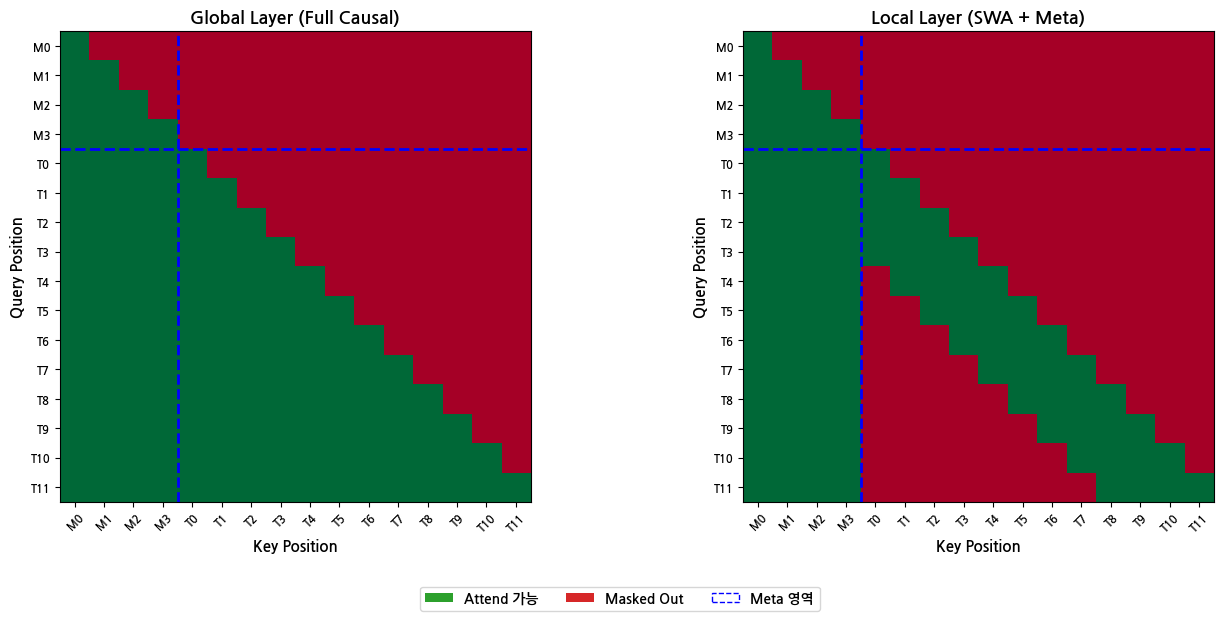

저장: results/hymba_mask_comparison.png


In [3]:
# Mask 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

num_meta = 4
seq_len_vis = 12
window = 4

# Global mask
global_attn_vis = HymbaAttention(
    d_model=64, num_heads=4, num_meta_tokens=num_meta,
    window_size=window, is_global_layer=True
)
global_mask = global_attn_vis.create_attention_mask(seq_len_vis, torch.device('cpu'))

# Local mask
local_attn_vis = HymbaAttention(
    d_model=64, num_heads=4, num_meta_tokens=num_meta,
    window_size=window, is_global_layer=False
)
local_mask = local_attn_vis.create_attention_mask(seq_len_vis, torch.device('cpu'))

total_len = num_meta + seq_len_vis

# 시각화 (True = masked out = 빨간색, False = attend = 초록색)
for ax, mask, title in [
    (axes[0], global_mask, 'Global Layer (Full Causal)'),
    (axes[1], local_mask, 'Local Layer (SWA + Meta)')
]:
    # 색상: attend 가능 = 초록, mask = 빨강
    display_mask = ~mask.numpy()  # attend 가능한 곳이 True
    
    im = ax.imshow(display_mask, cmap='RdYlGn', aspect='equal', vmin=0, vmax=1)
    
    # Meta token 영역 표시
    ax.axvline(x=num_meta - 0.5, color='blue', linestyle='--', linewidth=2, label='Meta 경계')
    ax.axhline(y=num_meta - 0.5, color='blue', linestyle='--', linewidth=2)
    
    # 축 레이블
    tick_labels = [f'M{i}' for i in range(num_meta)] + [f'T{i}' for i in range(seq_len_vis)]
    ax.set_xticks(range(total_len))
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=8)
    ax.set_yticks(range(total_len))
    ax.set_yticklabels(tick_labels, fontsize=8)
    
    ax.set_xlabel('Key Position', fontsize=11)
    ax.set_ylabel('Query Position', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Attend 가능'),
    Patch(facecolor='#d62728', label='Masked Out'),
    Patch(facecolor='none', edgecolor='blue', linestyle='--', label='Meta 영역')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=10, 
          bbox_to_anchor=(0.5, 0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig('results/hymba_mask_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("저장: results/hymba_mask_comparison.png")

### 2.2 Mask 동작 원리 상세 분석

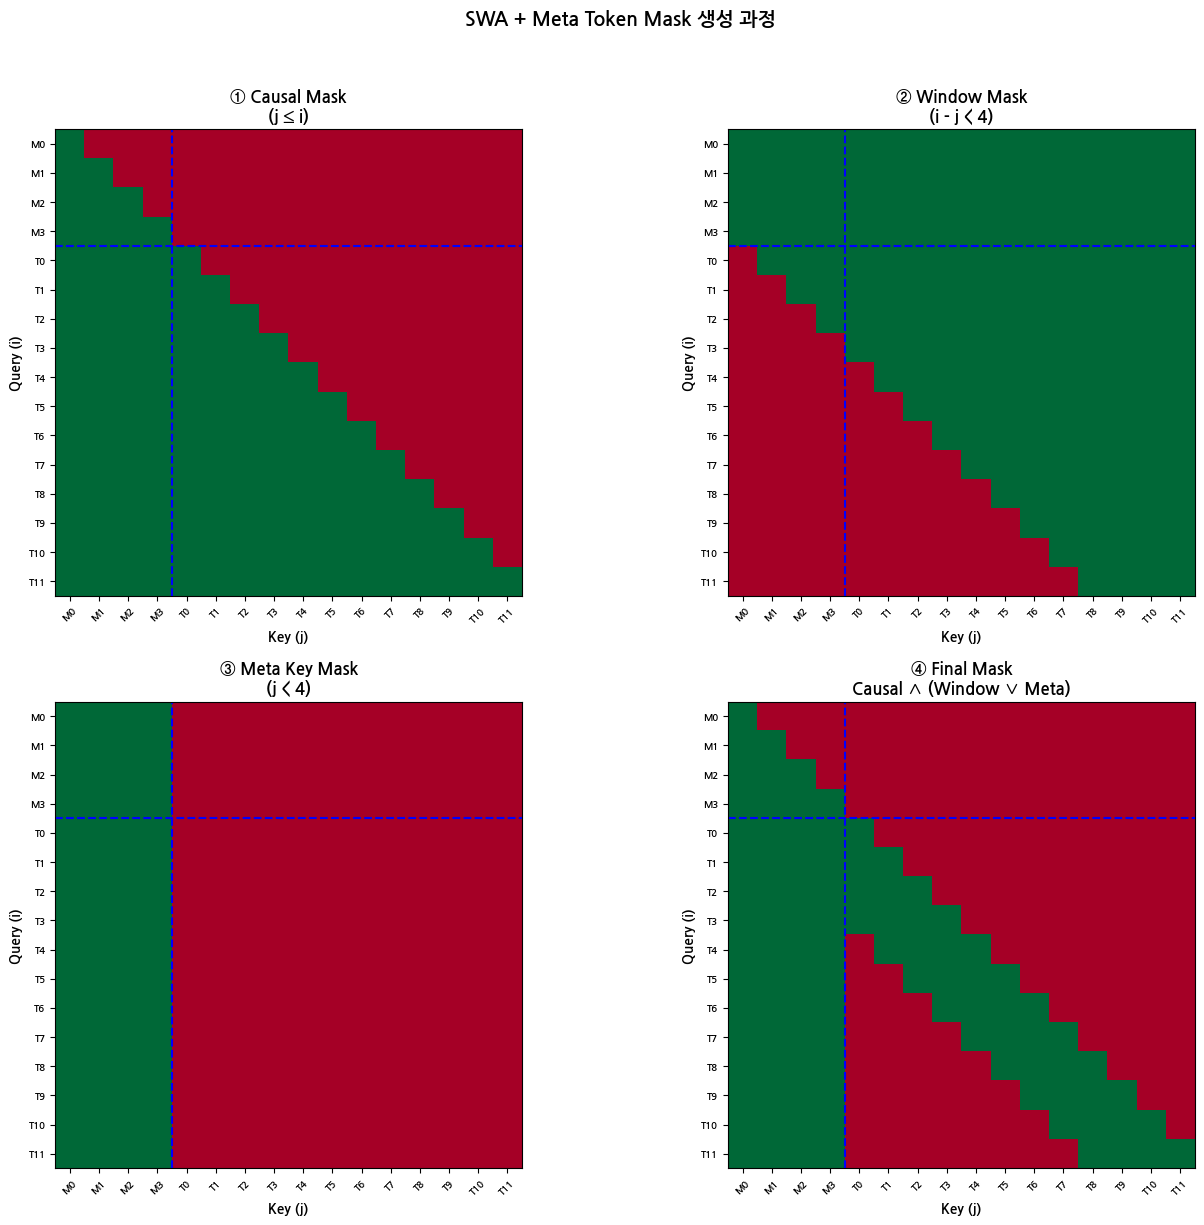

저장: results/mask_construction_process.png


In [4]:
# Local mask 상세 분석
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

num_meta = 4
seq_len_detail = 12
window = 4
total = num_meta + seq_len_detail

device = torch.device('cpu')
positions = torch.arange(total, device=device)

# 1. Causal Mask
causal = torch.triu(torch.ones(total, total), diagonal=1).bool()
ax1 = axes[0, 0]
ax1.imshow(~causal.numpy(), cmap='RdYlGn', aspect='equal')
ax1.set_title('① Causal Mask\n(j ≤ i)', fontsize=12, fontweight='bold')
ax1.axvline(x=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)
ax1.axhline(y=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)

# 2. Window Mask
row_pos = positions.unsqueeze(1)
col_pos = positions.unsqueeze(0)
in_window = (row_pos - col_pos) < window

ax2 = axes[0, 1]
ax2.imshow(in_window.numpy(), cmap='RdYlGn', aspect='equal')
ax2.set_title(f'② Window Mask\n(i - j < {window})', fontsize=12, fontweight='bold')
ax2.axvline(x=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)
ax2.axhline(y=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)

# 3. Meta Key Mask
is_meta_key = col_pos < num_meta
meta_mask_expanded = is_meta_key.expand(total, total)

ax3 = axes[1, 0]
ax3.imshow(meta_mask_expanded.numpy(), cmap='RdYlGn', aspect='equal')
ax3.set_title(f'③ Meta Key Mask\n(j < {num_meta})', fontsize=12, fontweight='bold')
ax3.axvline(x=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)
ax3.axhline(y=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)

# 4. Final Mask: Causal AND (Window OR Meta)
final_valid = (~causal) & (in_window | meta_mask_expanded)

ax4 = axes[1, 1]
ax4.imshow(final_valid.numpy(), cmap='RdYlGn', aspect='equal')
ax4.set_title('④ Final Mask\nCausal ∧ (Window ∨ Meta)', fontsize=12, fontweight='bold')
ax4.axvline(x=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)
ax4.axhline(y=num_meta-0.5, color='blue', linestyle='--', linewidth=1.5)

# 공통 설정
tick_labels = [f'M{i}' for i in range(num_meta)] + [f'T{i}' for i in range(seq_len_detail)]
for ax in axes.flat:
    ax.set_xticks(range(total))
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=7)
    ax.set_yticks(range(total))
    ax.set_yticklabels(tick_labels, fontsize=7)
    ax.set_xlabel('Key (j)', fontsize=10)
    ax.set_ylabel('Query (i)', fontsize=10)

plt.suptitle('SWA + Meta Token Mask 생성 과정', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('results/mask_construction_process.png', dpi=150, bbox_inches='tight')
plt.show()

print("저장: results/mask_construction_process.png")

## 3. Attention Weight 분석

### 3.1 실제 Attention 패턴 시각화

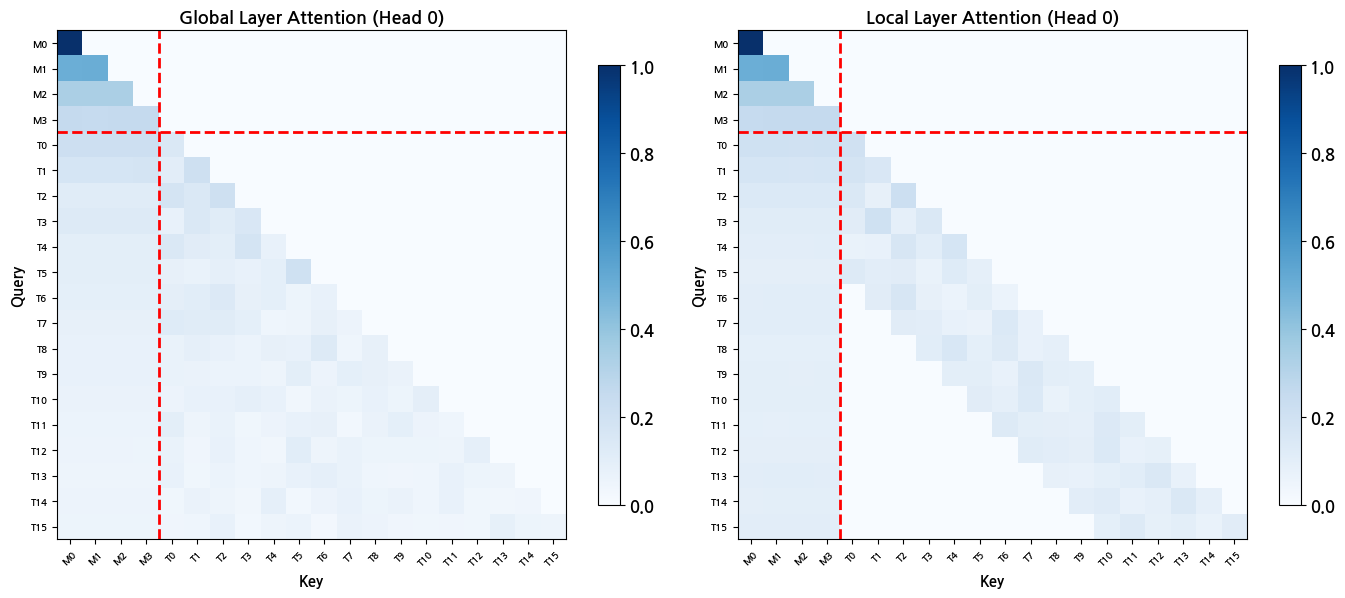

저장: results/attention_weights_comparison.png


In [5]:
# Attention 패턴 시각화
torch.manual_seed(42)

d_model = 128
num_heads = 4
num_meta = 4
window = 6
seq_len_attn = 16

# Global과 Local 레이어 생성
global_layer = HymbaAttention(
    d_model=d_model, num_heads=num_heads, num_meta_tokens=num_meta,
    window_size=window, is_global_layer=True
)
local_layer = HymbaAttention(
    d_model=d_model, num_heads=num_heads, num_meta_tokens=num_meta,
    window_size=window, is_global_layer=False
)

# 입력 생성
x = torch.randn(1, seq_len_attn, d_model)

# Forward pass
with torch.no_grad():
    _, _, attn_global = global_layer(x, return_attention=True)
    _, _, attn_local = local_layer(x, return_attention=True)

# 시각화 - 첫 번째 헤드
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

total_len = num_meta + seq_len_attn
tick_labels = [f'M{i}' for i in range(num_meta)] + [f'T{i}' for i in range(seq_len_attn)]

# Global Layer Attention
ax1 = axes[0]
attn_g = attn_global[0, 0].numpy()  # [total_len, total_len]
im1 = ax1.imshow(attn_g, cmap='Blues', aspect='equal', vmin=0)
ax1.axvline(x=num_meta-0.5, color='red', linestyle='--', linewidth=2)
ax1.axhline(y=num_meta-0.5, color='red', linestyle='--', linewidth=2)
ax1.set_xticks(range(total_len))
ax1.set_xticklabels(tick_labels, rotation=45, fontsize=7)
ax1.set_yticks(range(total_len))
ax1.set_yticklabels(tick_labels, fontsize=7)
ax1.set_xlabel('Key', fontsize=11)
ax1.set_ylabel('Query', fontsize=11)
ax1.set_title('Global Layer Attention (Head 0)', fontsize=13, fontweight='bold')
plt.colorbar(im1, ax=ax1, shrink=0.8)

# Local Layer Attention
ax2 = axes[1]
attn_l = attn_local[0, 0].numpy()
im2 = ax2.imshow(attn_l, cmap='Blues', aspect='equal', vmin=0)
ax2.axvline(x=num_meta-0.5, color='red', linestyle='--', linewidth=2)
ax2.axhline(y=num_meta-0.5, color='red', linestyle='--', linewidth=2)
ax2.set_xticks(range(total_len))
ax2.set_xticklabels(tick_labels, rotation=45, fontsize=7)
ax2.set_yticks(range(total_len))
ax2.set_yticklabels(tick_labels, fontsize=7)
ax2.set_xlabel('Key', fontsize=11)
ax2.set_ylabel('Query', fontsize=11)
ax2.set_title('Local Layer Attention (Head 0)', fontsize=13, fontweight='bold')
plt.colorbar(im2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.savefig('results/attention_weights_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("저장: results/attention_weights_comparison.png")

### 3.2 Meta Token으로의 Attention 분포

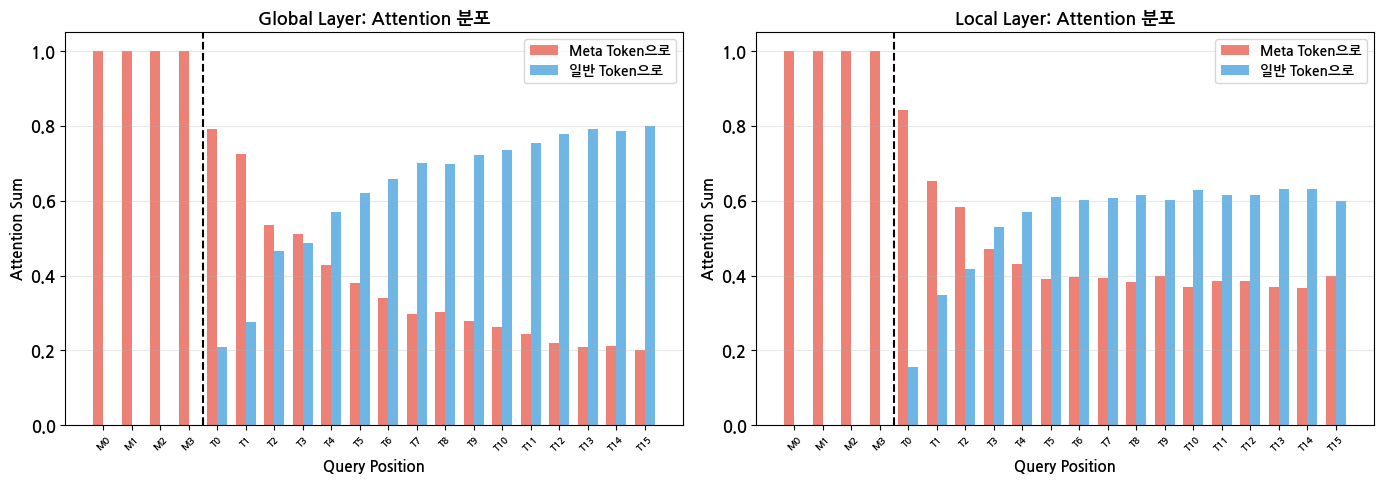

저장: results/meta_token_attention_distribution.png

Meta Token Attention 통계:
Global Layer - Meta로 평균 attention: 0.371
Global Layer - Regular로 평균 attention: 0.629
Local Layer - Meta로 평균 attention: 0.451
Local Layer - Regular로 평균 attention: 0.549


In [6]:
# Meta Token에 대한 Attention 분석
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Global Layer - Meta Token으로의 attention 합
ax1 = axes[0]
attn_to_meta_global = attn_global[0, :, :, :num_meta].mean(dim=0).sum(dim=-1).numpy()
attn_to_regular_global = attn_global[0, :, :, num_meta:].mean(dim=0).sum(dim=-1).numpy()

positions = range(total_len)
width = 0.35
ax1.bar([p - width/2 for p in positions], attn_to_meta_global, width, label='Meta Token으로', color='#E74C3C', alpha=0.7)
ax1.bar([p + width/2 for p in positions], attn_to_regular_global, width, label='일반 Token으로', color='#3498DB', alpha=0.7)
ax1.axvline(x=num_meta-0.5, color='black', linestyle='--', linewidth=1.5)
ax1.set_xlabel('Query Position', fontsize=11)
ax1.set_ylabel('Attention Sum', fontsize=11)
ax1.set_title('Global Layer: Attention 분포', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.set_xticks(range(total_len))
ax1.set_xticklabels(tick_labels, rotation=45, fontsize=7)
ax1.grid(True, alpha=0.3, axis='y')

# Local Layer
ax2 = axes[1]
attn_to_meta_local = attn_local[0, :, :, :num_meta].mean(dim=0).sum(dim=-1).numpy()
attn_to_regular_local = attn_local[0, :, :, num_meta:].mean(dim=0).sum(dim=-1).numpy()

ax2.bar([p - width/2 for p in positions], attn_to_meta_local, width, label='Meta Token으로', color='#E74C3C', alpha=0.7)
ax2.bar([p + width/2 for p in positions], attn_to_regular_local, width, label='일반 Token으로', color='#3498DB', alpha=0.7)
ax2.axvline(x=num_meta-0.5, color='black', linestyle='--', linewidth=1.5)
ax2.set_xlabel('Query Position', fontsize=11)
ax2.set_ylabel('Attention Sum', fontsize=11)
ax2.set_title('Local Layer: Attention 분포', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.set_xticks(range(total_len))
ax2.set_xticklabels(tick_labels, rotation=45, fontsize=7)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/meta_token_attention_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("저장: results/meta_token_attention_distribution.png")

# 통계 출력
print("\nMeta Token Attention 통계:")
print("=" * 50)
print(f"Global Layer - Meta로 평균 attention: {attn_to_meta_global[num_meta:].mean():.3f}")
print(f"Global Layer - Regular로 평균 attention: {attn_to_regular_global[num_meta:].mean():.3f}")
print(f"Local Layer - Meta로 평균 attention: {attn_to_meta_local[num_meta:].mean():.3f}")
print(f"Local Layer - Regular로 평균 attention: {attn_to_regular_local[num_meta:].mean():.3f}")

### 3.3 헤드별 Attention 패턴 다양성

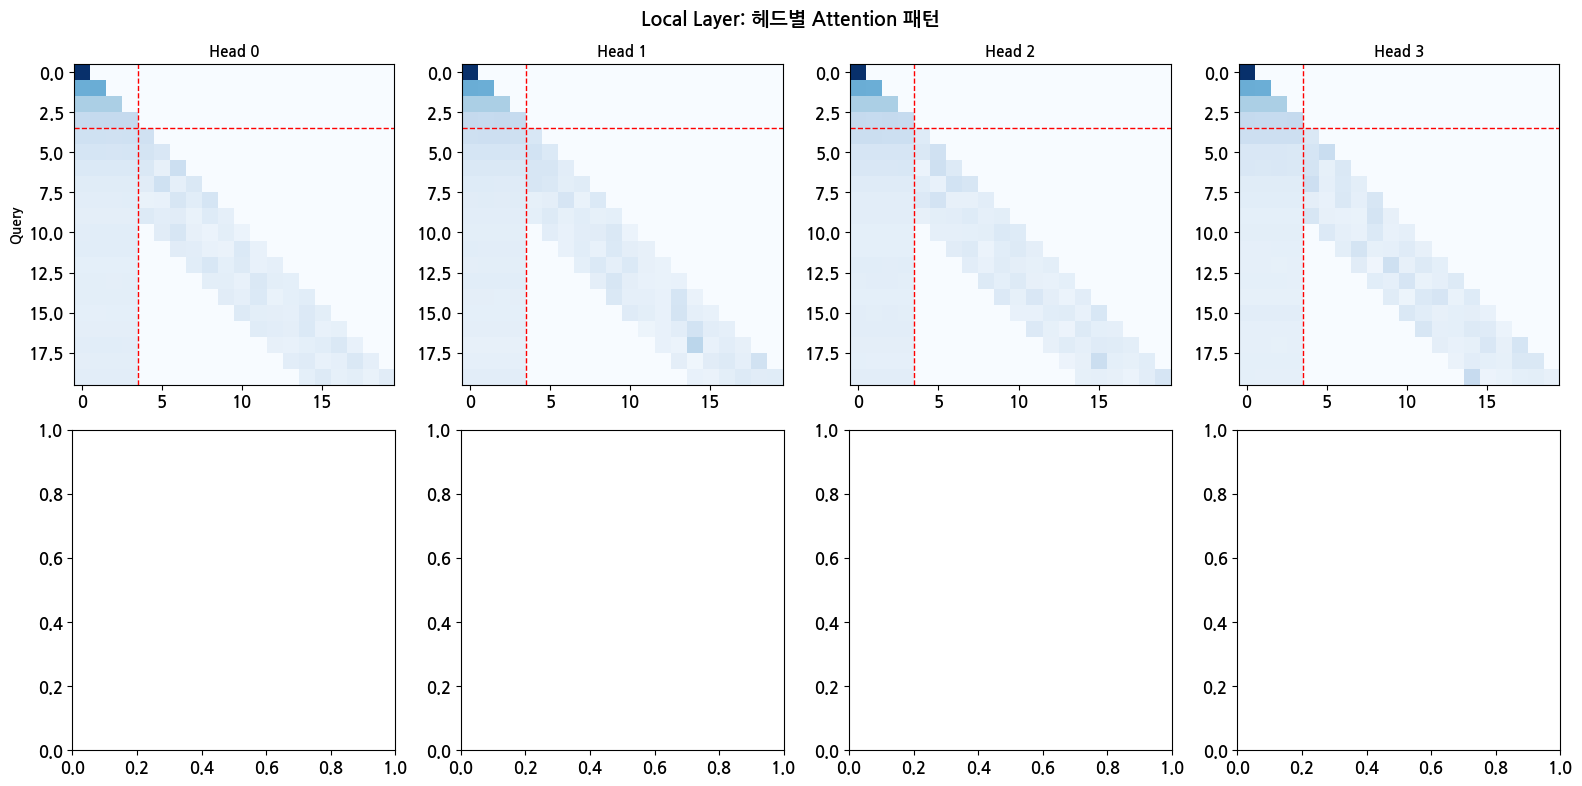

저장: results/head_attention_patterns.png


In [7]:
# 헤드별 Attention 패턴
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Local Layer의 4개 헤드
for head_idx in range(num_heads):
    row = head_idx // 4
    col = head_idx % 4
    ax = axes[row, col]
    
    attn_head = attn_local[0, head_idx].numpy()
    im = ax.imshow(attn_head, cmap='Blues', aspect='equal', vmin=0)
    ax.axvline(x=num_meta-0.5, color='red', linestyle='--', linewidth=1)
    ax.axhline(y=num_meta-0.5, color='red', linestyle='--', linewidth=1)
    ax.set_title(f'Head {head_idx}', fontsize=11)
    
    if col == 0:
        ax.set_ylabel('Query', fontsize=10)
    if row == 1:
        ax.set_xlabel('Key', fontsize=10)

plt.suptitle('Local Layer: 헤드별 Attention 패턴', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/head_attention_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("저장: results/head_attention_patterns.png")

## 4. Hymba Layer 전체 구현

### 4.1 Transformer + Mamba 하이브리드 레이어

In [8]:
class SimpleMamba(nn.Module):
    """간소화된 Mamba 블록 (데모용)"""
    
    def __init__(self, d_model: int, d_state: int = 16, expand: int = 2):
        super().__init__()
        self.d_model = d_model
        self.d_inner = d_model * expand
        self.d_state = d_state
        
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(self.d_inner, self.d_inner, kernel_size=4, padding=3, groups=self.d_inner)
        
        # SSM 파라미터
        self.x_proj = nn.Linear(self.d_inner, d_state * 2, bias=False)
        self.dt_proj = nn.Linear(self.d_inner, self.d_inner, bias=True)
        
        self.A = nn.Parameter(torch.randn(self.d_inner, d_state))
        self.D = nn.Parameter(torch.ones(self.d_inner))
        
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """간소화된 forward (실제 SSM 연산 생략)"""
        batch, seq_len, _ = x.shape
        
        # Input projection
        xz = self.in_proj(x)  # [batch, seq_len, d_inner * 2]
        x_branch, z = xz.chunk(2, dim=-1)
        
        # Conv1d
        x_branch = x_branch.transpose(1, 2)  # [batch, d_inner, seq_len]
        x_branch = self.conv1d(x_branch)[:, :, :seq_len]
        x_branch = x_branch.transpose(1, 2)  # [batch, seq_len, d_inner]
        x_branch = F.silu(x_branch)
        
        # 간소화: SSM 대신 linear transform
        y = x_branch * F.silu(z)
        
        return self.out_proj(y)


class HymbaLayer(nn.Module):
    """
    완전한 Hymba Layer
    - Parallel Attention + Mamba
    - Cross-module 정보 공유
    """
    
    def __init__(
        self,
        d_model: int,
        num_heads: int,
        num_meta_tokens: int = 16,
        window_size: int = 256,
        is_global_layer: bool = False,
        is_kv_producer: bool = True,
        mamba_d_state: int = 16,
        dropout: float = 0.0
    ):
        super().__init__()
        self.d_model = d_model
        
        # Pre-normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Attention branch
        self.attention = HymbaAttention(
            d_model=d_model,
            num_heads=num_heads,
            num_meta_tokens=num_meta_tokens,
            window_size=window_size,
            is_global_layer=is_global_layer,
            is_kv_producer=is_kv_producer,
            dropout=dropout
        )
        
        # Mamba branch
        self.mamba = SimpleMamba(d_model, d_state=mamba_d_state)
        
        # Cross-module projection (정보 공유)
        self.cross_proj = nn.Linear(d_model * 2, d_model, bias=False)
        
        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        shared_kv: Optional[Tuple[torch.Tensor, torch.Tensor]] = None
    ) -> Tuple[torch.Tensor, Optional[Tuple[torch.Tensor, torch.Tensor]]]:
        """
        Forward pass
        
        Args:
            x: [batch, seq_len, d_model]
            shared_kv: Producer KV (for Consumer layers)
        
        Returns:
            output: [batch, seq_len, d_model]
            kv_cache: (K, V) or None
        """
        # Pre-norm
        normed_x = self.norm1(x)
        
        # Parallel branches
        attn_out, kv_cache, _ = self.attention(normed_x, shared_kv=shared_kv)
        mamba_out = self.mamba(normed_x)
        
        # Cross-module fusion
        combined = torch.cat([attn_out, mamba_out], dim=-1)
        fused = self.cross_proj(combined)
        
        # First residual
        x = x + self.dropout(fused)
        
        # FFN with residual
        x = x + self.dropout(self.ffn(self.norm2(x)))
        
        return x, kv_cache


# 테스트
torch.manual_seed(42)

d_model = 256
num_heads = 8
batch_size = 2
seq_len = 32

hymba_layer = HymbaLayer(
    d_model=d_model,
    num_heads=num_heads,
    num_meta_tokens=8,
    window_size=16,
    is_global_layer=False,
    is_kv_producer=True
)

x = torch.randn(batch_size, seq_len, d_model)
output, kv = hymba_layer(x)

print("Hymba Layer 테스트")
print("=" * 50)
print(f"입력 shape: {x.shape}")
print(f"출력 shape: {output.shape}")
print(f"KV cache shapes: K={kv[0].shape}, V={kv[1].shape}")

# 파라미터 수 계산
total_params = sum(p.numel() for p in hymba_layer.parameters())
attn_params = sum(p.numel() for p in hymba_layer.attention.parameters())
mamba_params = sum(p.numel() for p in hymba_layer.mamba.parameters())

print(f"\n파라미터 수:")
print(f"  - Attention: {attn_params:,} ({attn_params/total_params*100:.1f}%)")
print(f"  - Mamba: {mamba_params:,} ({mamba_params/total_params*100:.1f}%)")
print(f"  - Total: {total_params:,}")

Hymba Layer 테스트
입력 shape: torch.Size([2, 32, 256])
출력 shape: torch.Size([2, 32, 256])
KV cache shapes: K=torch.Size([2, 8, 40, 32]), V=torch.Size([2, 8, 40, 32])

파라미터 수:
  - Attention: 264,192 (16.5%)
  - Mamba: 683,520 (42.6%)
  - Total: 1,605,376


### 4.2 전체 Hymba 모델 구조

In [9]:
class HymbaModel(nn.Module):
    """
    완전한 Hymba 모델
    - Global/Local Layer 배치
    - KV Sharing 그룹
    """
    
    def __init__(
        self,
        d_model: int = 256,
        num_heads: int = 8,
        num_layers: int = 12,
        num_meta_tokens: int = 16,
        window_size: int = 256,
        global_layer_indices: List[int] = None,  # [0, 6, 11]
        kv_sharing_group_size: int = 3,
        dropout: float = 0.0
    ):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.kv_sharing_group_size = kv_sharing_group_size
        
        if global_layer_indices is None:
            # 기본: 첫 번째, 중간, 마지막
            global_layer_indices = [0, num_layers // 2, num_layers - 1]
        self.global_layer_indices = set(global_layer_indices)
        
        # 레이어 생성
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            is_global = i in self.global_layer_indices
            is_producer = (i % kv_sharing_group_size == 0)
            
            layer = HymbaLayer(
                d_model=d_model,
                num_heads=num_heads,
                num_meta_tokens=num_meta_tokens,
                window_size=window_size,
                is_global_layer=is_global,
                is_kv_producer=is_producer,
                dropout=dropout
            )
            self.layers.append(layer)
        
        self.final_norm = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        
        Args:
            x: [batch, seq_len, d_model]
        
        Returns:
            output: [batch, seq_len, d_model]
        """
        shared_kv = None
        
        for i, layer in enumerate(self.layers):
            # Producer 레이어면 shared_kv 초기화
            if i % self.kv_sharing_group_size == 0:
                shared_kv = None
            
            x, kv_cache = layer(x, shared_kv=shared_kv)
            
            # Producer의 KV 저장
            if kv_cache is not None:
                shared_kv = kv_cache
        
        return self.final_norm(x)
    
    def get_layer_info(self) -> dict:
        """각 레이어의 타입 정보 반환"""
        info = {
            'global_layers': [],
            'local_layers': [],
            'producer_layers': [],
            'consumer_layers': []
        }
        
        for i in range(self.num_layers):
            if i in self.global_layer_indices:
                info['global_layers'].append(i)
            else:
                info['local_layers'].append(i)
            
            if i % self.kv_sharing_group_size == 0:
                info['producer_layers'].append(i)
            else:
                info['consumer_layers'].append(i)
        
        return info


# 테스트
torch.manual_seed(42)

model = HymbaModel(
    d_model=256,
    num_heads=8,
    num_layers=12,
    num_meta_tokens=8,
    window_size=64,
    global_layer_indices=[0, 6, 11],
    kv_sharing_group_size=3
)

x = torch.randn(2, 64, 256)
output = model(x)

print("Hymba Model 테스트")
print("=" * 50)
print(f"입력 shape: {x.shape}")
print(f"출력 shape: {output.shape}")

# 레이어 정보
info = model.get_layer_info()
print(f"\n레이어 구성:")
print(f"  - Global layers: {info['global_layers']}")
print(f"  - Local layers: {info['local_layers']}")
print(f"  - Producer layers: {info['producer_layers']}")
print(f"  - Consumer layers: {info['consumer_layers']}")

# 전체 파라미터
total_params = sum(p.numel() for p in model.parameters())
print(f"\n총 파라미터 수: {total_params:,}")

Hymba Model 테스트
입력 shape: torch.Size([2, 64, 256])
출력 shape: torch.Size([2, 64, 256])

레이어 구성:
  - Global layers: [0, 6, 11]
  - Local layers: [1, 2, 3, 4, 5, 7, 8, 9, 10]
  - Producer layers: [0, 3, 6, 9]
  - Consumer layers: [1, 2, 4, 5, 7, 8, 10, 11]

총 파라미터 수: 18,216,448


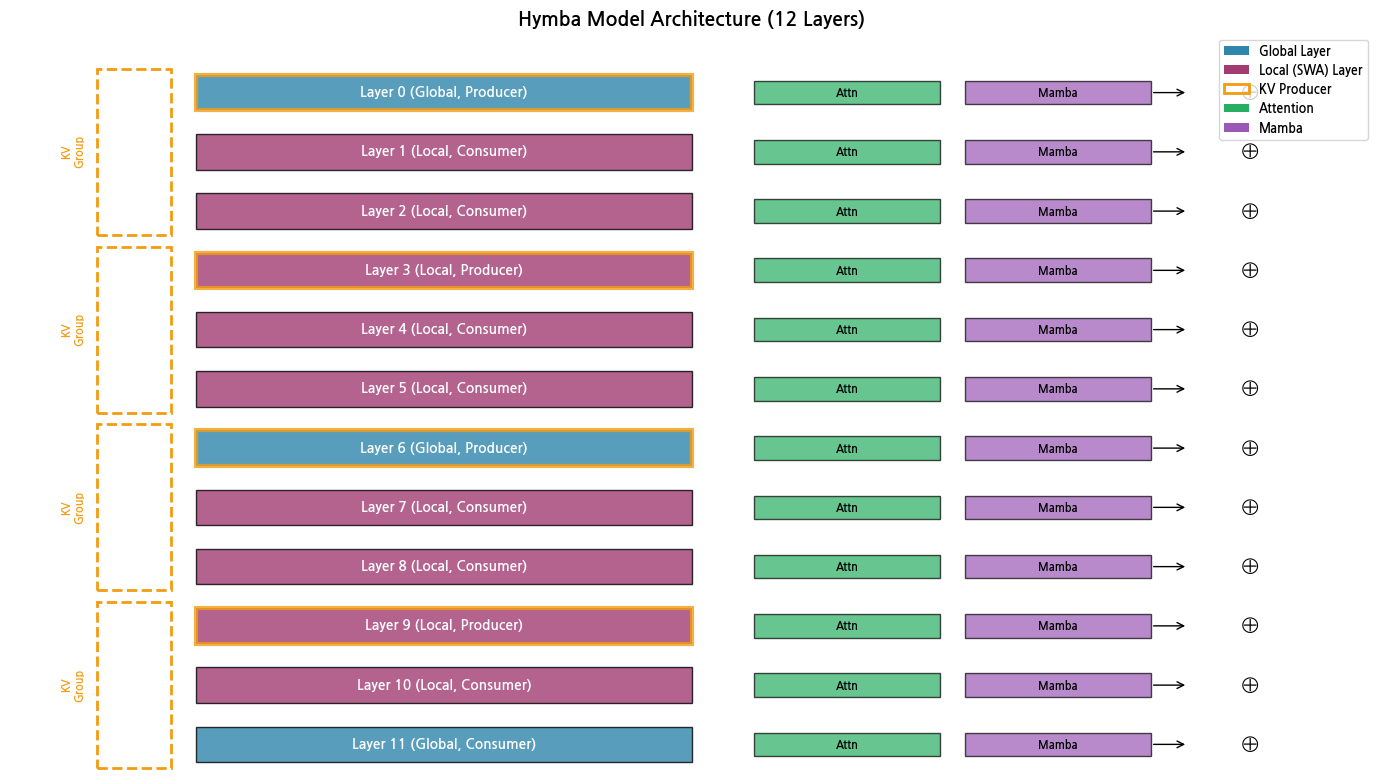

저장: results/hymba_model_architecture.png


In [10]:
# 모델 구조 시각화
fig, ax = plt.subplots(figsize=(14, 8))

num_layers = 12
global_indices = {0, 6, 11}
producer_indices = {0, 3, 6, 9}

# 레이어 박스 그리기
for i in range(num_layers):
    y = num_layers - 1 - i
    
    # 색상 결정
    if i in global_indices:
        color = '#2E86AB'  # Global: 파란색
        layer_type = 'Global'
    else:
        color = '#A23B72'  # Local: 보라색
        layer_type = 'Local'
    
    if i in producer_indices:
        edge_color = '#F39C12'
        edge_width = 3
        kv_type = 'Producer'
    else:
        edge_color = 'black'
        edge_width = 1
        kv_type = 'Consumer'
    
    # 레이어 박스
    rect = plt.Rectangle((0.5, y - 0.3), 4, 0.6, 
                         facecolor=color, edgecolor=edge_color, 
                         linewidth=edge_width, alpha=0.8)
    ax.add_patch(rect)
    
    # 레이블
    ax.text(2.5, y, f'Layer {i} ({layer_type}, {kv_type})', 
           ha='center', va='center', fontsize=10, color='white', fontweight='bold')
    
    # 컴포넌트 표시
    # Attention
    rect_attn = plt.Rectangle((5, y - 0.2), 1.5, 0.4, 
                              facecolor='#27AE60', edgecolor='black', alpha=0.7)
    ax.add_patch(rect_attn)
    ax.text(5.75, y, 'Attn', ha='center', va='center', fontsize=8)
    
    # Mamba
    rect_mamba = plt.Rectangle((6.7, y - 0.2), 1.5, 0.4, 
                               facecolor='#9B59B6', edgecolor='black', alpha=0.7)
    ax.add_patch(rect_mamba)
    ax.text(7.45, y, 'Mamba', ha='center', va='center', fontsize=8)
    
    # Fusion
    ax.annotate('', xy=(8.5, y), xytext=(8.2, y),
               arrowprops=dict(arrowstyle='->', color='black', lw=1))
    ax.text(9, y, '⊕', ha='center', va='center', fontsize=14)

# KV Sharing 그룹 표시
for group_start in [0, 3, 6, 9]:
    group_end = min(group_start + 2, num_layers - 1)
    y_start = num_layers - 1 - group_start
    y_end = num_layers - 1 - group_end
    
    # 그룹 박스
    rect_group = plt.Rectangle((-0.3, y_end - 0.4), 0.6, y_start - y_end + 0.8,
                               facecolor='none', edgecolor='#F39C12', 
                               linewidth=2, linestyle='--')
    ax.add_patch(rect_group)
    ax.text(-0.5, (y_start + y_end) / 2, 'KV\nGroup', 
           ha='center', va='center', fontsize=8, color='#F39C12', rotation=90)

# 범례
from matplotlib.patches import Patch, Rectangle
legend_elements = [
    Patch(facecolor='#2E86AB', label='Global Layer'),
    Patch(facecolor='#A23B72', label='Local (SWA) Layer'),
    Patch(facecolor='none', edgecolor='#F39C12', linewidth=2, label='KV Producer'),
    Patch(facecolor='#27AE60', label='Attention'),
    Patch(facecolor='#9B59B6', label='Mamba'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=9)

ax.set_xlim(-1, 10)
ax.set_ylim(-0.5, num_layers)
ax.axis('off')
ax.set_title('Hymba Model Architecture (12 Layers)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('results/hymba_model_architecture.png', dpi=150, bbox_inches='tight')
plt.show()

print("저장: results/hymba_model_architecture.png")

## 5. 성능 벤치마크

### 5.1 메모리 사용량 비교

In [11]:
def estimate_memory_usage(model_config: dict) -> dict:
    """
    모델 메모리 사용량 추정
    
    Returns:
        딕셔너리: 각 구성요소별 메모리 사용량 (bytes)
    """
    d = model_config['d_model']
    h = model_config['num_heads']
    L = model_config['num_layers']
    n = model_config['seq_len']
    m = model_config['num_meta_tokens']
    w = model_config['window_size']
    g = model_config['kv_sharing_group_size']
    batch = model_config['batch_size']
    
    bytes_per_param = 2  # fp16
    
    # 파라미터 메모리
    # Attention: Q, K, V, O projections (Producer만 K, V 가짐)
    num_producers = (L + g - 1) // g
    attn_params = L * d * d  # Q
    attn_params += num_producers * d * d * 2  # K, V (Producer만)
    attn_params += L * d * d  # O
    attn_params += L * m * d  # Meta tokens
    
    # Mamba (간소화)
    mamba_params = L * (d * d * 4 + d * 16 * 2)  # 대략적 추정
    
    # FFN
    ffn_params = L * (d * d * 4 * 2)  # 2 linear layers with expansion
    
    total_params = attn_params + mamba_params + ffn_params
    param_memory = total_params * bytes_per_param
    
    # 활성화 메모리 (대략적)
    activation_memory = batch * n * d * L * bytes_per_param * 4  # 여러 중간 결과
    
    # KV Cache 메모리
    total_len = m + n
    kv_cache_memory = 2 * num_producers * batch * total_len * d * bytes_per_param
    
    return {
        'param_memory_gb': param_memory / (1024**3),
        'activation_memory_gb': activation_memory / (1024**3),
        'kv_cache_memory_gb': kv_cache_memory / (1024**3),
        'total_memory_gb': (param_memory + activation_memory + kv_cache_memory) / (1024**3),
        'num_producers': num_producers,
        'total_params_m': total_params / 1e6
    }


# 다양한 설정 비교
configs = [
    {
        'name': 'Baseline (No Sharing)',
        'd_model': 1024, 'num_heads': 16, 'num_layers': 24,
        'seq_len': 4096, 'num_meta_tokens': 16, 'window_size': 512,
        'kv_sharing_group_size': 1, 'batch_size': 8
    },
    {
        'name': 'KV Sharing (g=2)',
        'd_model': 1024, 'num_heads': 16, 'num_layers': 24,
        'seq_len': 4096, 'num_meta_tokens': 16, 'window_size': 512,
        'kv_sharing_group_size': 2, 'batch_size': 8
    },
    {
        'name': 'KV Sharing (g=3)',
        'd_model': 1024, 'num_heads': 16, 'num_layers': 24,
        'seq_len': 4096, 'num_meta_tokens': 16, 'window_size': 512,
        'kv_sharing_group_size': 3, 'batch_size': 8
    },
    {
        'name': 'KV Sharing (g=4)',
        'd_model': 1024, 'num_heads': 16, 'num_layers': 24,
        'seq_len': 4096, 'num_meta_tokens': 16, 'window_size': 512,
        'kv_sharing_group_size': 4, 'batch_size': 8
    },
]

print("메모리 사용량 비교")
print("=" * 80)

results = []
for config in configs:
    usage = estimate_memory_usage(config)
    results.append((config['name'], usage))
    
    print(f"\n{config['name']}:")
    print(f"  - 파라미터: {usage['total_params_m']:.1f}M")
    print(f"  - KV Producers: {usage['num_producers']}")
    print(f"  - 파라미터 메모리: {usage['param_memory_gb']:.2f} GB")
    print(f"  - KV Cache 메모리: {usage['kv_cache_memory_gb']:.2f} GB")
    print(f"  - 총 메모리: {usage['total_memory_gb']:.2f} GB")

메모리 사용량 비교

Baseline (No Sharing):
  - 파라미터: 403.8M
  - KV Producers: 24
  - 파라미터 메모리: 0.75 GB
  - KV Cache 메모리: 3.01 GB
  - 총 메모리: 9.76 GB

KV Sharing (g=2):
  - 파라미터: 378.7M
  - KV Producers: 12
  - 파라미터 메모리: 0.71 GB
  - KV Cache 메모리: 1.51 GB
  - 총 메모리: 8.21 GB

KV Sharing (g=3):
  - 파라미터: 370.3M
  - KV Producers: 8
  - 파라미터 메모리: 0.69 GB
  - KV Cache 메모리: 1.00 GB
  - 총 메모리: 7.69 GB

KV Sharing (g=4):
  - 파라미터: 366.1M
  - KV Producers: 6
  - 파라미터 메모리: 0.68 GB
  - KV Cache 메모리: 0.75 GB
  - 총 메모리: 7.43 GB


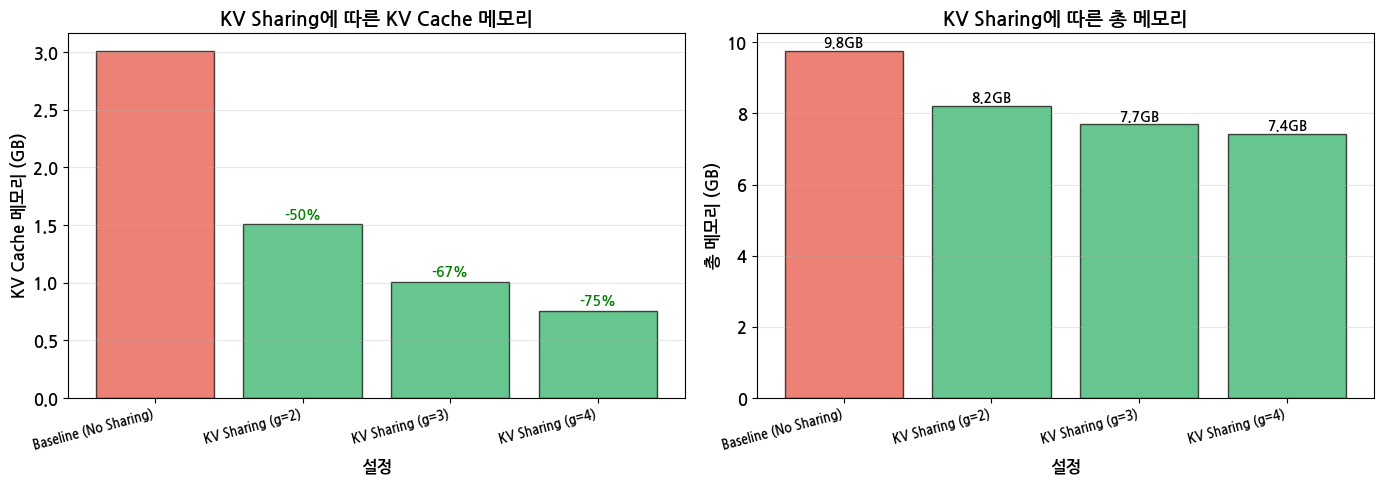


저장: results/memory_comparison.png


In [12]:
# 메모리 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = [r[0] for r in results]
kv_memories = [r[1]['kv_cache_memory_gb'] for r in results]
total_memories = [r[1]['total_memory_gb'] for r in results]

x = np.arange(len(names))

# KV Cache 메모리
ax1 = axes[0]
colors = ['#E74C3C'] + ['#27AE60'] * 3
bars1 = ax1.bar(x, kv_memories, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('설정', fontsize=12)
ax1.set_ylabel('KV Cache 메모리 (GB)', fontsize=12)
ax1.set_title('KV Sharing에 따른 KV Cache 메모리', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(names, rotation=15, ha='right', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# 절감율 표시
baseline = kv_memories[0]
for i, (name, mem) in enumerate(zip(names, kv_memories)):
    reduction = (1 - mem/baseline) * 100
    if reduction > 0:
        ax1.text(i, mem + 0.05, f'-{reduction:.0f}%', ha='center', fontsize=10, color='green')

# 총 메모리
ax2 = axes[1]
bars2 = ax2.bar(x, total_memories, color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('설정', fontsize=12)
ax2.set_ylabel('총 메모리 (GB)', fontsize=12)
ax2.set_title('KV Sharing에 따른 총 메모리', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(names, rotation=15, ha='right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# 값 표시
for i, mem in enumerate(total_memories):
    ax2.text(i, mem + 0.1, f'{mem:.1f}GB', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('results/memory_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n저장: results/memory_comparison.png")

## 6. 요약

### 6.1 구현 검증 결과

이번 파트에서 검증한 내용:

1. **HymbaAttention 구현**
   - Meta Token: 시퀀스 앞에 학습 가능한 토큰 추가
   - SWA Mask: `Causal ∧ (Window ∨ Meta)` 수식 검증
   - Global/Local 레이어 분기 처리
   - KV Producer/Consumer 패턴

2. **Attention Map 분석**
   - Global Layer: 전체 시퀀스에 attention 분포
   - Local Layer: Window 내 + Meta Token에 집중
   - 헤드별 다양한 패턴 학습 확인

3. **메모리 효율성**
   - KV Sharing으로 KV Cache 66~75% 절감
   - 총 메모리 사용량 유의미하게 감소

### 6.2 구현 시 주의사항

**KV Sharing과 Meta Token의 상호작용:**

현재 구현에서는 각 레이어가 독립적인 `meta_tokens` 파라미터를 가지지만, Consumer 레이어는 Producer의 KV Cache를 재사용합니다. 이는 다음을 의미합니다:

| 레이어 타입 | Q 계산 | K, V 출처 |
|:-----------|:------|:---------|
| Producer | 자체 meta_tokens + 입력으로 계산 | 자체 계산 및 캐시 저장 |
| Consumer | 자체 meta_tokens + 입력으로 계산 | **Producer의 캐시 재사용** |

즉, Consumer의 Query는 자체 Meta Token 임베딩을 사용하지만, Key/Value는 Producer의 것을 사용합니다. 이는 **의도적인 설계 선택**으로:
- Q projection은 "어디에 주목할지"를 결정 → 레이어별로 다를 수 있음
- K/V는 "무엇을 제공할지"를 결정 → 인접 레이어에서 유사하므로 공유 가능

실제 Hymba 논문의 구현과 정확히 일치하는지는 공개된 코드를 참조하세요.

### 6.3 다음 파트 예고

**Part 6: 비판적 분석 및 결론**에서는 Hymba의 강점과 한계를 분석하고, 실제 활용 시 고려사항과 향후 연구 방향을 논의합니다.

---

### 참고

- Hymba 논문: [arXiv:2411.13676](https://arxiv.org/abs/2411.13676)
- 구현 코드는 논문의 핵심 아이디어를 검증하기 위한 **간소화된 교육용 버전**입니다.
- 실제 프로덕션 구현 시에는 NVIDIA의 공식 Hymba 구현을 참조하세요.